In [1]:
using Plots
include("polyfit_function.jl")
include("Lagrange_interpolation.jl")

Lagrange (generic function with 1 method)

In [2]:
# Two-step Adams Bashforth Scheme (Explicit)

function ab2(f, tspan, y0, N)
    h = (tspan[2] - tspan[1]) / N
    t = Vector(range(tspan[1], tspan[2], length=N+1))
    y = zeros(N + 1, 1)
    y[1] = y0
    k1=h*f(t[1], y[1])
    k2=h*f(t[1]+h, y[1]+k1)
    y[2]=y[1]+0.5*(k1+k2)
    # Two -step AB steps
    for i in 1:(N-1)
        y[i + 2] = y[i + 1] + (3/2) *h* f(t[i+1], y[i+1]) - 0.5 *h* f(t[i], y[i])
    end

    return t, y
end

ab2 (generic function with 1 method)

In [ ]:
function trapz(f, tspan,lambda, y0, N)
    h = (tspan[2] - tspan[1]) / N
    t = Vector(range(tspan[1], tspan[2], length=N+1))
    y = zeros(N + 1, 1)
    y[1] = y0
    #k1=h*f(t[1], y[1])
    #k2=h*f(t[1]+h, y[1]+k1)
    #y[2]=y[1]+0.5*(k1+k2)
    for i in 1:N
        y[i + 1] = (y[i] + 0.5*h*lambda*y[i])/(1-0.5*h*lambda)
    end

    return t, y
end

In [ ]:
# Convergence Analysis of Trapezoidal method
y0 = 1.0
lambda=-1
tspan=[0 1.0]
K = 10
err = zeros(K, 1)
ns=zeros(K, 1)
for k in 1:K
    N = 20* 2^k
    ns[k]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y) = lambda * y
    (t, y) = trapz(f, tspan, lambda, y0, N)
    exact = y0 * exp.(lambda * t)
    
    # Storing errors
    for i in 1:K+1
        err[k] = norm(exact[N+1] .- y[N+1])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Provisional")
display(plot!(legend=:topright))

In [3]:
# Hard coded trapezoidal for y'=lambda*y

function ridc_ab2_trp(f, tspan, h, lambda, y0, N, K)
    
    # Embedding AB-2 into RIDC
    # AB-2 update takes the form 
    # y_(n+1)= y_n + (3/2)*h*f(t_n, y_n) - (1/2)*h*f(t_(n-1), y_(n-1)).
    
    y=zeros(1, N+1, K+1)
    
    t, y[1, :, 1]=ab2(f, tspan, y0, N) # storing the provisional solution
   
   for k in 1:K
        y[1, 1, k+1]=y0 # initial condition
        nfval=f(t, y[1, :, k]) # New function value
        
        # (2k+2) equi-spaced nodes are used where k is the iteration number. 
        
        # First step hard coded by Trapzoidal method
        Qdr1=Lagrange(t[1:2*k+2], nfval[1:2*k+2], t[1], t[2])
        
        
        c1=(y[1, 1, k+1]-0.5*h*lambda*y[1, 2, k]+0.5*h*lambda*y[1,1,k+1]- 0.5*h*lambda*y[1, 1, k])
       
        
        #y[1, 2, k+1]= (c1 + Qdr1)/(1-0.5*h*lambda)
         
        # exact starting condition. seems to work
        #y[1, 2, k+1]= y0 * exp.(lambda*t[2])
        
        # exp(x) = 1 + x + x^2/2! + x^3/3! + ...
        
        # 1st order (specifically Euler) starting condition.  breaks
        #y[1,2,k+1] = y0*(1+lambda*h)
        
        # (**) 2nd order starting condition. this seems to work.  don't know why
        #y[1, 2, k+1]= y0*(1+lambda*h+lambda^2*h^2/2)
        
        # ben is solving the original ivp using rk2 to get a starting value for y1.
        # A = [0 0, 1, 0], b = [1/2 1/2] c = [0 1]
        #k1 = lambda*h*y0
        #k2 = lambda*h*(y0+k1)
        #y[1,2,k+1] = y0 + k1/2 + k2/2
        # based on (**), this would work for some strange reason to be explained.

        # if you use RK2 to solve the error equation, it should recover
        # y1 = y0*(1+lambda*h+lambda^2*h^2/2 + lambda^3*h^3/6 + lambda^4*h^4/24) + O(h^5)
    
        # Ben would expect this to work:
        y[1, 2, k+1]= y0*(1+lambda*h+lambda^2*h^2/2 + lambda^3*h^3/6 + lambda^4*h^4/24 -2.5*lambda^5*h^5/120)
        
        # any RK2 scheme: will recover y1 = y0*(1+lambda*h+lambda^2*h^2/2) + O(h^3)
        
        # First nth steps
        for n in 3:(2*k+1)
            Qdr= Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-1], t[n])
            b1= (3/2)* h*(f(t[n-1], y[1, n-1, k+1]) - f(t[n-1], y[1, n-1, k]))
            b2= (1/2)* h*(f(t[n-2], y[1, n-2, k+1]) - f(t[n-2], y[1, n-2, k]))
            y[1, n, k+1]= y[1, n-1, k+1] + b1 - b2 + Qdr
        end
        
        for j in (2*k+2):(N+1)
            Qdr = Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-1], t[j])
            b1= (3/2)* h*(f(t[j-1], y[1, j-1, k+1]) - f(t[j-1], y[1, j-1, k]))
            b2= (1/2)* h*(f(t[j-2], y[1, j-2, k+1]) - f(t[j-2], y[1, j-2, k]))
            y[1, j, k+1]= y[1, j-1, k+1] + b1 - b2 + Qdr
        end
            
    end
    return t,  y
end

ridc_ab2_trp (generic function with 1 method)

convergence order = 2.031755821496556
convergence order = 4.043337632105393
convergence order = 5.613596373564506
convergence order = 4.983657261320889


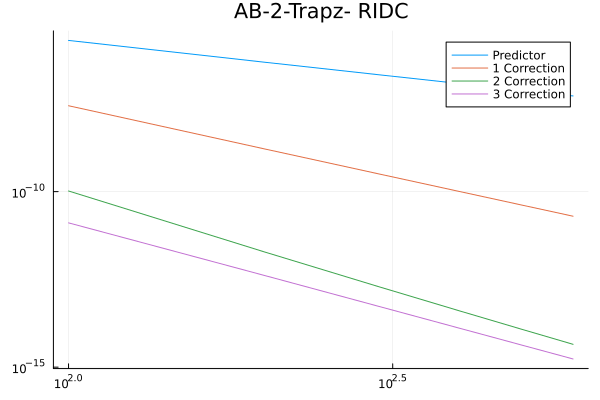

In [44]:
# Example 1: y'=lambda* y, y(0)=1; T in [0, 10]

using Plots
P = 6
y0 = 1.0
lambda=-1
tspan=[0 10]
K = 3
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 100*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y) = lambda * y
    
    (t, y) = ridc_ab2_trp(f, tspan, h, lambda, y0, N, K)
    
    exact = y0 * exp.(lambda * t)
   
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n")
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, title="AB-2-Trapz- RIDC", label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))

In [5]:
# Hard coded trapezoidal for y'=-y+sin(10t)

function ridc_ab2_trp_ex2(f, tspan, h, y0, N, K)
    
    # Embedding AB-2 into RIDC
    # AB-2 update takes the form 
    # y_(n+1)= y_n + (3/2)*h*f(t_n, y_n) - (1/2)*h*f(t_(n-1), y_(n-1)).
    
    y=zeros(1, N+1, K+1)
    
    t, y[1, :, 1]=ab2(f, tspan, y0, N) # storing the provisional solution
   
   for k in 1:K
        y[1, 1, k+1]=y0 # initial condition
        nfval=f(t, y[1, :, k]) # New function value
        
        # (2k+2) equi-spaced nodes are used where k is the iteration number. 
        
        # First step computed by Trapzoidal method
        Qdr1=Lagrange(t[1:2*k+2], nfval[1:2*k+2], t[1], t[2])
        
        
        c1=(y[1, 1, k+1]+0.5*h*y[1, 2, k]-0.5*h*y[1,1,k+1]+ 0.5*h*y[1, 1, k])
       
        
        y[1, 2, k+1]= (c1 + Qdr1)/(1+0.5*h)
        
        
        # First nth steps
        for n in 3:(2*k+1)
            Qdr= Lagrange(t[1:(2*k+2)], nfval[1:(2*k+2)], t[n-1], t[n])
            b1= (3/2)* h*(f(t[n-1], y[1, n-1, k+1]) - f(t[n-1], y[1, n-1, k]))
            b2= (1/2)* h*(f(t[n-2], y[1, n-2, k+1]) - f(t[n-2], y[1, n-2, k]))
            y[1, n, k+1]= y[1, n-1, k+1] + b1 - b2 + Qdr
        end
        
        for j in (2*k+2):(N+1)
            Qdr = Lagrange(t[j-(2*k+1):j], nfval[j-(2*k+1):j], t[j-1], t[j])
            b1= (3/2)* h*(f(t[j-1], y[1, j-1, k+1]) - f(t[j-1], y[1, j-1, k]))
            b2= (1/2)* h*(f(t[j-2], y[1, j-2, k+1]) - f(t[j-2], y[1, j-2, k]))
            y[1, j, k+1]= y[1, j-1, k+1] + b1 - b2 + Qdr
        end
            
    end
    return t,  y
end

ridc_ab2_trp_ex2 (generic function with 1 method)

convergence order = 2.016595099712512
convergence order = 3.998837836515827
convergence order = 6.044414615839476
convergence order = 5.295784490675519


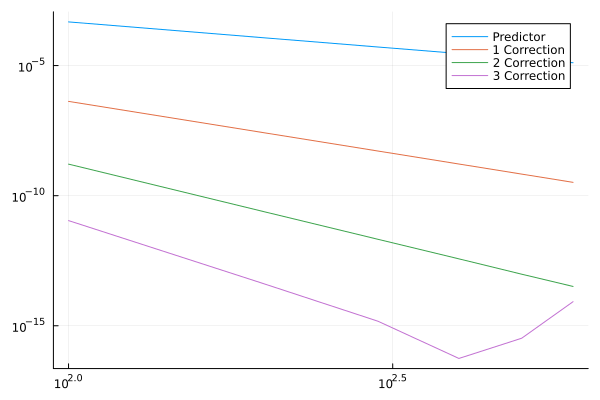

In [6]:
# Example 2: y'= - y .+ sin.(10*t) , y(0)=1; T in [0, 1]

using Plots
P = 6
y0 = 1.0

tspan=[0 1]
K = 3
err = zeros(P, K + 1)
ns=zeros(P, 1)
for p in 1:P
    N = 100*p
    ns[p]=N
    h = (tspan[2] - tspan[1]) / N
    f(t, y)= - y .+ sin.(10*t)
    (t, y) = ridc_ab2_trp_ex2(f, tspan, h, y0, N, K)
    exact= -(1/101)* exp.(-t) .*(-111 .+10*exp.(t) .*cos.(10*t).- exp.(t) .*sin.(10*t))
    # Storing errors
    
    # Storing errors
    for i in 1:K+1
        err[p, i] = norm(exact[N+1] .- y[1, N+1, i])
    end
end

# Compute order of convergence and error plot
pdeg = polyfit(log10.(ns[:]), log10.(err[:, 1]),1)
print("convergence order = ",abs(pdeg[2]),"\n") 
plot(ns, err[:, 1],xaxis=:log, yaxis=:log, label="Predictor")

for j in 2:K+1
    plot!(ns, err[:,j],xaxis=:log, yaxis=:log, label="$(j-1) Correction")
    pdeg = polyfit(log10.(ns[:]), log10.(err[:, j]),1)
    print("convergence order = ", abs(pdeg[2]),"\n")
end
display(plot!(legend=:topright))